# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xmltodict

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim

import xmltodict
from tqdm import tqdm

# Reading files
All the images are stored in img_names list and annotations in xml_names list.

In [4]:
img_names=[]
xml_names=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/face_mask_detection'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

len(img_names)

853

In [5]:
len(xml_names)

854

In [6]:
path_annotations="/content/drive/MyDrive/face_mask_detection/annotations/"
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])


Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


# Image Preprocessing

In [7]:
path_image="/content/drive/MyDrive/face_mask_detection/images/"
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}

In [8]:
def custom_dataset(image_list):
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(transform(image))
                label_tensor.append(torch.tensor(label))

    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


In [9]:
transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=custom_dataset(img_names)

In [10]:
mydataset[0]

[tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          ...,
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216]],
 
         [[0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ...,

# Splitting Dataset into Training and Test Set

In [11]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [12]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

# Samples in Training Set

DataLoader() is an iterable that abstracts this complexity for us in an easy API. When shuffle is made true data is shuffled, after the iteration is over for all batches.


In [13]:
train_dataloader =DataLoader(dataset=trainset,batch_size=64,shuffle=True,num_workers=2)
test_dataloader =DataLoader(dataset=testset,batch_size=64,shuffle=True,num_workers=2)

In [95]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [96]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 226, 226])
Labels batch shape: torch.Size([64])


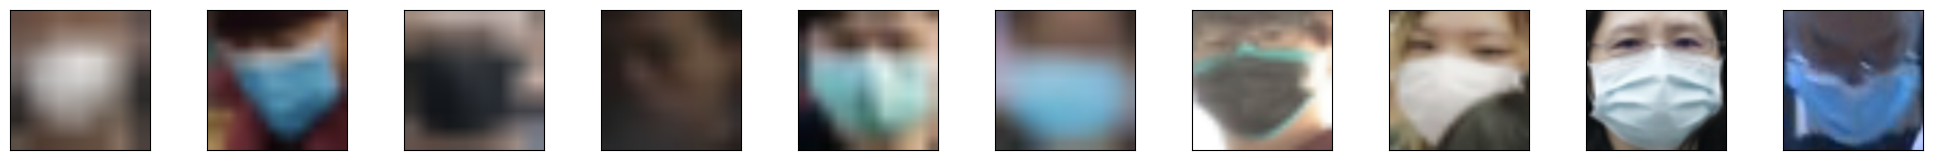

In [97]:
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))


# Model Building

# Download the resnet34 layers pre-trained model

In [148]:
model=models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [149]:
for param in model.parameters():
    param.requires_grad=False

# Model Details


To view different layers representing different operations 'model name' is to be executed.

In [150]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

we replace the last linear layer with 1000 ouput features with linear layer which output 3 ouput feature each for a output class

In [151]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : 3


In [152]:
features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

features_resnet34

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [153]:
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# Training Model

In [154]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False


In [155]:
def predict_class(y_train):
  y_class = []
  for i in range(len(y_train)):
    idx = 0
    num = y_train[i][0];
    for j in range(1, 3):
      if(y_train[i][j] > num):
        idx = j
        num = y_train[i][j]
    y_class.append(idx)
  return torch.tensor(y_class)

In [156]:
def predict(model, loader) :
  # num_correct_val = 0
  num_samples_val = 0
  num_correct_val = torch.tensor(0).to(device)
  model.eval()
  for batch, (X_val, y_val) in enumerate(loader):
    #if torch.cuda.is_available():
    #X_train , y_train = X_train.cuda(), y_train.cuda()

    X_val = X_val.to(device)
    y_val = y_val.to(device)

    val_preds = model(X_val)
    val_loss = loss_function(val_preds, y_val)
    val_class = predict_class(val_preds)
    val_class.to(device)
    with torch.no_grad():
        rounded_val_preds = torch.round(val_class).to(device)
        # rounded_val_preds.to(device)
        num_correct_val += torch.sum(rounded_val_preds == y_val).to(device)
        num_samples_val += len(val_class)

  val_acc = num_correct_val/num_samples_val
  model.train()
  return val_acc , val_loss

In [157]:
def model_train(model, optimizer, num_epoch):
  train_loss_arr = []
  train_acc_arr = []
  val_loss_arr = []
  val_acc_arr = []

  for epoch in range(num_epoch):

    num_correct_train = torch.tensor(0)
    num_correct_train = num_correct_train.to(device)
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        #if torch.cuda.is_available():
        #X_train , y_train = X_train.cuda(), y_train.cuda()

        X_train = X_train.to(device)
        y_train = y_train.to(device)

        train_preds = model(X_train)
        # print('shape of train_preds ', train_preds[0:4, :])
        # print('shape of y_train ', y_train[0:6])
        train_loss = loss_function(train_preds, y_train)
        y_train_class = predict_class(train_preds)
        y_train_class.to(device)
        # print("y_train_class", y_train_class)
        with torch.no_grad():
            rounded_train_preds = torch.round(y_train_class).to(device)
            num_correct_train += torch.sum(rounded_train_preds == y_train).to(device)
            num_samples_train += len(y_train_class)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_acc = num_correct_train/num_samples_train
    val_acc, val_loss = predict(model,test_dataloader)

    #print(train_loss)
    #print(train_acc)
    train_loss_arr.append(train_loss.item())
    train_acc_arr.append(train_acc.item())
    val_acc_arr.append(val_acc.item())
    val_loss_arr.append(val_loss.item())

    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(val_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(val_acc.item(),2)}')

  return train_loss_arr , train_acc_arr, val_loss_arr, val_acc_arr

In [158]:
model.to(device)
model.train()
t = model_train(model, optimizer, 15)

100%|██████████| 45/45 [00:06<00:00,  6.58it/s]


Epoch: 0 	| Train loss: 0.319 	| Test loss: 0.537 	| Train acc: 0.76 	| Test acc: 0.84


100%|██████████| 45/45 [00:07<00:00,  6.37it/s]


Epoch: 1 	| Train loss: 0.245 	| Test loss: 0.162 	| Train acc: 0.85 	| Test acc: 0.87


100%|██████████| 45/45 [00:06<00:00,  6.83it/s]


Epoch: 2 	| Train loss: 0.361 	| Test loss: 0.2 	| Train acc: 0.89 	| Test acc: 0.9


100%|██████████| 45/45 [00:06<00:00,  6.96it/s]


Epoch: 3 	| Train loss: 0.322 	| Test loss: 0.088 	| Train acc: 0.9 	| Test acc: 0.9


100%|██████████| 45/45 [00:06<00:00,  6.53it/s]


Epoch: 4 	| Train loss: 0.313 	| Test loss: 0.524 	| Train acc: 0.9 	| Test acc: 0.91


100%|██████████| 45/45 [00:06<00:00,  6.80it/s]


Epoch: 5 	| Train loss: 0.211 	| Test loss: 0.306 	| Train acc: 0.9 	| Test acc: 0.91


100%|██████████| 45/45 [00:06<00:00,  6.51it/s]


Epoch: 6 	| Train loss: 0.2 	| Test loss: 0.158 	| Train acc: 0.91 	| Test acc: 0.92


100%|██████████| 45/45 [00:06<00:00,  6.61it/s]


Epoch: 7 	| Train loss: 0.246 	| Test loss: 0.136 	| Train acc: 0.91 	| Test acc: 0.93


100%|██████████| 45/45 [00:06<00:00,  6.62it/s]


Epoch: 8 	| Train loss: 0.249 	| Test loss: 0.118 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 45/45 [00:06<00:00,  6.96it/s]


Epoch: 9 	| Train loss: 0.109 	| Test loss: 0.041 	| Train acc: 0.91 	| Test acc: 0.93


100%|██████████| 45/45 [00:06<00:00,  6.65it/s]


Epoch: 10 	| Train loss: 0.209 	| Test loss: 0.152 	| Train acc: 0.92 	| Test acc: 0.93


100%|██████████| 45/45 [00:06<00:00,  6.61it/s]


Epoch: 11 	| Train loss: 0.416 	| Test loss: 0.18 	| Train acc: 0.92 	| Test acc: 0.92


100%|██████████| 45/45 [00:06<00:00,  6.98it/s]


Epoch: 12 	| Train loss: 0.366 	| Test loss: 0.186 	| Train acc: 0.92 	| Test acc: 0.93


100%|██████████| 45/45 [00:06<00:00,  6.92it/s]


Epoch: 13 	| Train loss: 0.189 	| Test loss: 0.391 	| Train acc: 0.92 	| Test acc: 0.93


100%|██████████| 45/45 [00:06<00:00,  6.54it/s]


Epoch: 14 	| Train loss: 0.414 	| Test loss: 0.033 	| Train acc: 0.92 	| Test acc: 0.93


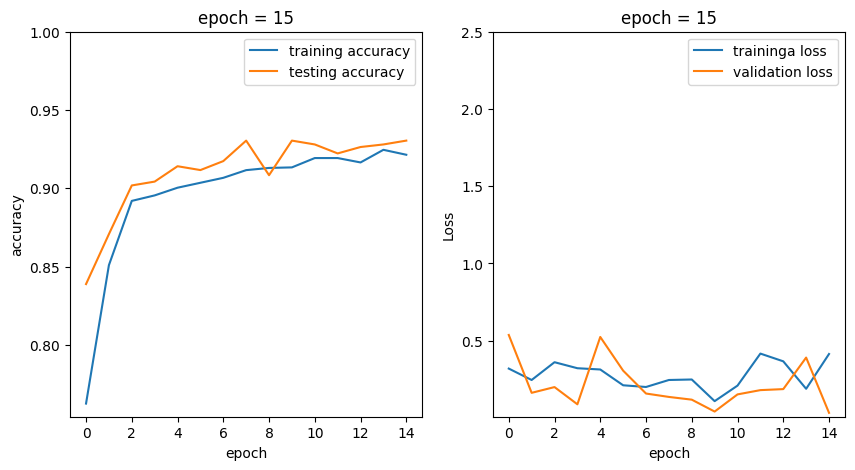

In [162]:
(train_loss, train_acc, val_loss,val_acc ) = t
#plt.figure(figsize=(1,1))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax1.plot(train_acc)
ax1.plot(val_acc)
ax1.legend(['training accuracy', 'testing accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('epoch = ' + str(15) )
ax1.set_ybound(None, 1)

ax2.plot(train_loss)
ax2.plot(val_loss)
ax2.legend(['traininga loss', 'validation loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('Loss')
ax2.set_title('epoch = ' + str(15) )
ax2.set_ybound(None, 2.5)

plt.show()